In [1]:
import torch 
from torchvision.models import resnet50,ResNet50_Weights,resnet152,ResNet152_Weights
import torchvision
import os
os.environ['TORCH_HOME']=r"D:\torch_model"

In [2]:
weights = torchvision.models.ResNet152_Weights.IMAGENET1K_V1
net = torchvision.models.resnet152(weights=weights)

In [3]:
from d2l import torch as d2l
from torch.utils.data import DataLoader,Dataset,Subset

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])
dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\LEVEL',transform=transforms)



In [5]:
from sklearn.model_selection import train_test_split
import datetime
indexs=torch.tensor(range(len(dataset)))
train_dataset_index,test_dataset_index=train_test_split(indexs,test_size=0.3,shuffle=False)
train_dataset=Subset(dataset=dataset,indices=train_dataset_index)
test_dataset=Subset(dataset=dataset,indices=test_dataset_index)
train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=128,shuffle=True)

timer, num_batches = d2l.Timer(), len(train_dataloader)
 
print(num_batches)


41


KeyboardInterrupt: 

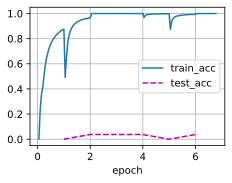

In [6]:
import torch.nn.functional as F
import torch
device=torch.device('cuda')
net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")
num_epochs=500
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FaceDetect",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)
animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])  
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data_dict in enumerate(train_dataloader):
        optim.zero_grad()
        x=data_dict[0].to(device)
        x=x+torch.randn_like(x).to(device) /100   
        y=data_dict[1].long().to(device)
        y_hat=net(x)
        l=F.cross_entropy(y_hat, y)
        l.mean().backward()
        optim.step()     
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        
        if (i + 1) % (num_batches // 20) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
        
    
    net.eval()
    with torch.no_grad():
        metric_test = d2l.Accumulator(2)
        for data_dict in test_dataloader:
            x=data_dict[0].to(torch.float32).to(device)
            y=data_dict[1].long().to(device)
            y_hat=net(x)
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_test.add(num_true,y.numel())
        animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))

        if best_test_acc<(metric_test[0]/metric_test[1]):
            best_test_acc=metric_test[0]/metric_test[1]
            stagnate_times=0
            
            
            torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_test_acc}.pt'))
        else:
            stagnate_times=stagnate_times+1
        
        if stagnate_times>50:
            break

# K折交叉

In [ ]:
from sklearn.model_selection import train_test_split
import datetime
#设定权重保存目录
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FaceClassfier",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)

dataset=torchvision.datasets.ImageFolder(root=r'D:\project_meta\NNproject\NNI\output\video_frames\LEVEL',transform=transforms)
timer, num_batches = d2l.Timer(), len(train_dataloader)

from sklearn.model_selection import KFold
 
kf = KFold(n_splits=10, shuffle=False)
AnimatorList=[]
for  kf_i,(train_index, val_index) in enumerate(kf.split(dataset)):
    # print(train_index, test_index)
    AnimatorList.append( d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc']))
    animator=AnimatorList[kf_i]
    train_fold = torch.utils.data.dataset.Subset(dataset, train_index)
    val_fold = torch.utils.data.dataset.Subset(dataset, val_index)   
    device=torch.device('cuda')
    net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
    optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
    loss=torch.nn.CrossEntropyLoss().to(device="cuda")
    num_epochs=500
    best_train_acc=0
    best_train_loss=0
    best_test_acc=0
    stagnate_times=0
    temp_acc=0

    animator = d2l.Animator(xlabel='epoch',
                            legend=['train_acc','test_acc'])  
    for epoch in range(num_epochs):
        metric_train = d2l.Accumulator(2)
        net.train()
        for i,data_dict in enumerate(train_dataloader):
            optim.zero_grad()
            x=data_dict[0].to(device)
            x=x+torch.randn_like(x).to(device) /100   
            y=data_dict[1].long().to(device)
            y_hat=net(x)
            l=F.cross_entropy(y_hat, y)
            l.mean().backward()
            optim.step()     
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_train.add(num_true,y.numel())
            
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
            
        
        net.eval()
        with torch.no_grad():
            metric_test = d2l.Accumulator(2)
            for data_dict in test_dataloader:
                x=data_dict[0].to(torch.float32).to(device)
                y=data_dict[1].long().to(device)
                y_hat=net(x)
                pre=torch.argmax(y_hat.detach().cpu(),dim=1)
                num_true=sum(pre==y.cpu())
                metric_test.add(num_true,y.numel())
            animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))

            if best_test_acc<(metric_test[0]/metric_test[1]):
                best_test_acc=metric_test[0]/metric_test[1]
                stagnate_times=0
                
                
                torch.save(net.state_dict(),os.path.join(parameterFolder,f'{kf_i}{best_test_acc}.pt'))
            else:
                stagnate_times=stagnate_times+1
            
            if stagnate_times>50:
                break 
    

In [ ]:
torch.cuda.empty_cache()

In [ ]:

from sklearn.metrics import confusion_matrix
import numpy as np
import torch
torch.cuda.empty_cache()
device=torch.device('cuda')
net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
net.eval()
with torch.no_grad():
    num_classes=3
    test_dataloader=DataLoader(test_dataset,batch_size=128)
    confusion_matrix_test = np.zeros((num_classes, num_classes))
    net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_14_09_19_09\0.7592592592592593.pt"))
    for data_dict in test_dataloader:
        x=data_dict[0].to(torch.float32).to(device)
        y=data_dict[1].long().to(device)
        y_hat=net(x)
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        y_pred = torch.stack((pre, y.cpu()), dim=1)
        confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))
    import seaborn as sns
    sns.heatmap(confusion_matrix_test,annot=True, fmt=".2f", cmap="Blues")

# 实验1 

In [13]:
def setProjectPath(projectPath):
    import os
    import sys
    root=os.path.abspath(projectPath)
    print(root)
    sys.path.append(root)
    os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
    import warnings  
    warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")

projectPath=r'D:\project_meta\NNproject\NNI'
setProjectPath(projectPath)
import mne
datasetFolder=r'D:\dataset\driver_dataset\DROZY\DROZY'
outputFolder=r'D:\project_meta\NNproject\NNI\output'
from project.dataprocess.FolderTree import *
datasetDict=getDataPath(datasetFolder)
outputDict=getOutPath(outputFolder)
import pprint
print('datasetfolder:')
pprint.pprint(datasetDict)
print('outputfolder:')
pprint.pprint(outputDict)


D:\project_meta\NNproject\NNI
datasetfolder:
{'annotation_auto_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\annotations-auto',
 'annotation_manual_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\annotations-manual',
 'kinect_file': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\kinect-intrinsics.yaml',
 'kss_file': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\KSS.txt',
 'psg_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\psg',
 'pvt_rt_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\pvt-rt',
 'videos_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\videos_i8'}
outputfolder:
{'ECG_table_file': 'D:\\project_meta\\NNproject\\NNI\\output\\ECG_table.csv',
 'EEG_table_file': 'D:\\project_meta\\NNproject\\NNI\\output\\EEG_table.csv',
 'bandpower_file': 'D:\\project_meta\\NNproject\\NNI\\output\\bandpower.csv',
 'cwt_folder': 'D:\\project_meta\\NNproject\\NNI\\output\\cwt',
 'filted_folder': 'D:\\project_meta\\NNproject\\NNI\\output\\psg_filted',
 'info_file': 'D:\\proj

In [10]:
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
IDFrameFolder=os.path.join(outputDict['video_frames'],'IDFolder')
print(IDFrameFolder)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图片大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])
data_dir = IDFrameFolder
dataset=ImageFolder(IDFrameFolder,transform)
person_folders = [os.path.join(data_dir, person) for person in os.listdir(data_dir)]

D:\project_meta\NNproject\NNI\output\video_frames\IDFolder


KeyboardInterrupt: 

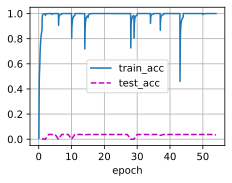

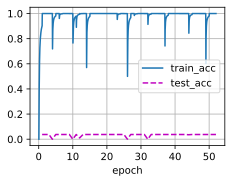

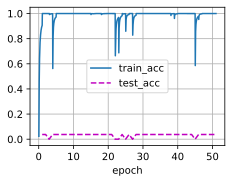

In [16]:
from sklearn.model_selection import KFold

personId=list(range(1,15))
AnimatorList=[]
kf = KFold(n_splits=7, shuffle=True, random_state=42)
for kf_i,(train_persons,test_persons) in enumerate(kf.split(person_folders)):
    # test_persons = [2, 5, 9]  # 假设选择第2、第5和第9个人作为测试集
    # train_persons = [idx for idx in range(0, 14) if idx not in test_persons]  # 其他人作为训练集

    # 创建测试集和训练集的数据加载器
    test_dataset = torch.utils.data.Subset(dataset, [person_folders[person] for person in test_persons])
    train_dataset = torch.utils.data.Subset(dataset, [person_folders[person] for person in train_persons])

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # 打印数据集信息
    print(f"总样本数： {len(dataset)}")
    print(f"测试集样本数：{len(test_dataset)}")
    print(f"训练集样本数：{len(train_dataset)}")
    import torch.nn.functional as F
    import torch
    device=torch.device('cuda')
    net=resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
    optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
    loss=torch.nn.CrossEntropyLoss().to(device="cuda")
    num_epochs=500
    best_train_acc=0
    best_train_loss=0
    best_test_acc=0
    stagnate_times=0
    temp_acc=0
    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
    parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FaceDetect",f"{formatted_time}")
    print(parameterFolder)
    os.makedirs(parameterFolder)
    AnimatorList.append( d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc']))
    animator=AnimatorList[kf_i] 
    for epoch in range(num_epochs):
        metric_train = d2l.Accumulator(2)
        net.train()
        for i,data_dict in enumerate(train_dataloader):
            optim.zero_grad()
            x=data_dict[0].to(device)
            x=x+torch.randn_like(x).to(device) /100   
            y=data_dict[1].long().to(device)
            y_hat=net(x)
            l=F.cross_entropy(y_hat, y)
            l.mean().backward()
            optim.step()     
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_train.add(num_true,y.numel())
            
            if (i + 1) % (num_batches // 20) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
            
        
        net.eval()
        with torch.no_grad():
            metric_test = d2l.Accumulator(2)
            for data_dict in test_dataloader:
                x=data_dict[0].to(torch.float32).to(device)
                y=data_dict[1].long().to(device)
                y_hat=net(x)
                pre=torch.argmax(y_hat.detach().cpu(),dim=1)
                num_true=sum(pre==y.cpu())
                metric_test.add(num_true,y.numel())
            animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))

            if best_test_acc<(metric_test[0]/metric_test[1]):
                best_test_acc=metric_test[0]/metric_test[1]
                stagnate_times=0
                
                
                torch.save(net.state_dict(),os.path.join(parameterFolder,f'{kf_i}_{best_test_acc}.pt'))
            else:
                stagnate_times=stagnate_times+1
            
            if stagnate_times>50:
                break

In [49]:
next(iter(train_dataloader))

[tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           ...,
           [-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9843, -0.9922],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9843, -0.9843],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9765, -0.9843]],
 
          [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           ...,
           [-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9843, -0.9922],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9843, -0.9843],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9765, -0.9843]],
 
          [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           [-